In [1]:
import cv2
import importlib
import itertools
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import os
import openslide
from openslide import open_slide
from pathlib import Path
import pandas as pd
from PIL import Image, ImageOps
import seaborn as sns
from scipy import ndimage
from skimage.filters import threshold_minimum, threshold_otsu
import sys
#from skimage.morphology import skeletonize

#Allow Pillow to open very large images
Image.MAX_IMAGE_PIXELS = None

#Check if OpenCV is using optimised code
cv2.useOptimized()

True

In [2]:
# Import HEMnet package
BASE_DIR = Path().resolve().parent
HEMNET_DIR = BASE_DIR.joinpath('HEMnet')
sys.path.append(str(HEMNET_DIR))

from slide import *
from utils import *
from normaliser import IterativeNormaliser

In [3]:
import utils
importlib.reload(utils)
from utils import *

In [4]:
ANNOTATIONS_PATH = Path('/QRISdata/Q1139/ST_Projects/HEMnet/Annotated_Jpegs_Green/Validation')
SLIDES_PATH = Path('/gpfs1/scratch/90days/s4436005/Slides')
#OUTPUT_PATH = Path('/gpfs1/scratch/90days/s4436005/img_reg/10_06_20_testing')
OUTPUT_PATH = Path('/QRISdata/Q1139/ST_Projects/HEMnet/Validation_Datasets/val_dataset_path_10x_23_06_20')
TEMPLATE_SLIDE_PATH = Path('/gpfs1/scratch/90days/s4436005/Slides/1957_T_9668_3_HandE.svs')

ALIGNMENT_MAG = 2
TILE_MAG = 10
#Allow user to select between 'none', 'reinhard', 'macenko' and 'vahadane'
NORMALISER_METHOD = "vahadane"
STANDARDISE_LUMINOSITY = True
VERBOSE = True

#Verbose functions
if VERBOSE:
    verbose_print = lambda *args: print(*args)
    verbose_save_img = lambda img, path, img_type: img.save(path, img_type)
    verbose_save_fig = lambda fig, path, dpi=300: fig.savefig(path, dpi=dpi)
else:
    verbose_print = lambda *args: None
    verbose_save_img = lambda *args: None
    verbose_save_fig = lambda *args: None

In [5]:
# Find annotated images 
annotated_imgs = []
for img in ANNOTATIONS_PATH.glob('*.jpg'):
    name = img.name
    annotated_imgs.append(name)
annotated_imgs.sort()
verbose_print('Found {0} annotated images'.format(len(annotated_imgs)))
for i, name in enumerate(annotated_imgs):
    verbose_print('{0}. {1}'.format(i + 1, name))

Found 5 annotated images
1. carlosjosesuarez_crcoutlines_170824_green_Page_07.jpg
2. carlosjosesuarez_crcoutlines_170824_green_Page_08.jpg
3. carlosjosesuarez_crcoutlines_170824_green_Page_09.jpg
4. carlosjosesuarez_crcoutlines_170824_green_Page_10.jpg
5. carlosjosesuarez_crcoutlines_170824_green_Page_12.jpg


In [6]:
# Find Slides
slides = []
for slide in SLIDES_PATH.glob('*.svs'):
    name = slide.name
    slides.append(name)
slides.sort()
#slides
TP53_slides = [slide for slide in slides if 'TP53' in slide]
HE_slides = [slide for slide in slides if 'HandE' in slide]
Paired_slides = list(zip(TP53_slides, HE_slides))
print('Found {0} pairs of slides'.format(len(Paired_slides)))
for i, pair in enumerate(Paired_slides):
    tp53, he = pair
    verbose_print('{0}. {1}|{2}'.format(i + 1, tp53, he))

Found 35 pairs of slides
1. 1792_T_9500_2_TP53.svs|1792_T_9500_3_HandE.svs
2. 1794_T_9504_2_TP53.svs|1794_T_9504_3_HandE.svs
3. 1798_T_9514_2_TP53.svs|1798_T_9514_3_HandE.svs
4. 1820_N_10545A_4_TP53.svs|1820_N_10545A_2_HandE.svs
5. 1820_T_105452F_4_TP53.svs|1820_T_105452F_2_HandE.svs
6. 1843_T_9561_2_TP53.svs|1843_T_9561_3_HandE.svs
7. 1879_T_9580_2_TP53.svs|1879_T_9580_3_HandE.svs
8. 1910_T_9637_2_TP53.svs|1910_T_9637_3_HandE.svs
9. 1915_T_10464_2_TP53.svs|1915_T_10464_3_HandE.svs
10. 1919_T_10779_2_TP53.svs|1919_T_10779_3_HandE.svs
11. 1928_T_9644_2_TP53.svs|1928_T_9644_3_HandE.svs
12. 1932_T_9876_2_TP53.svs|1932_T_9876_3_HandE.svs
13. 1939_T_9661_2_TP53.svs|1939_T_9661_3_HandE.svs
14. 1957_T_9668_2_TP53.svs|1957_T_9668_3_HandE.svs
15. 2011_T_9699_2_TP53.svs|2011_T_9699_3_HandE.svs
16. 2019_T_9717_2_TP53.svs|2019_T_9717_3_HandE.svs
17. 2023_T_9727_2_TP53.svs|2023_T_9727_3_HandE.svs
18. 2036_T_9729_2_TP53.svs|2036_T_9729_3_HandE.svs
19. 2038_T_11986_2_TP53.svs|2038_T_11986_3_HandE.svs

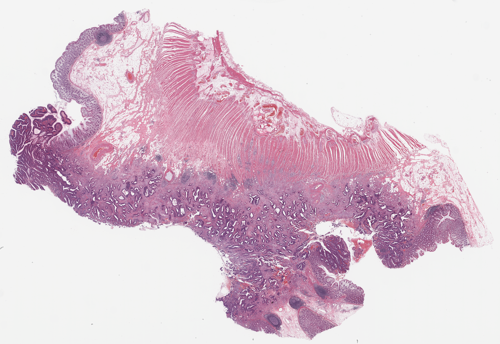

In [7]:
template_slide = open_slide(str(TEMPLATE_SLIDE_PATH))
template_img = read_slide_at_mag(template_slide, ALIGNMENT_MAG).convert('RGB')

thumbnail(template_img, (500,500))

In [8]:
normaliser = IterativeNormaliser(NORMALISER_METHOD, STANDARDISE_LUMINOSITY)
normaliser.fit_target(template_img)

In [9]:
#Track how many tiles are exported
tile_counts_df = pd.DataFrame({})
tile_counts_df['slide_name'] = np.nan
tile_counts_df['cancer'] = np.nan
tile_counts_df['non-cancer'] = np.nan
tile_counts_df['other'] = np.nan

In [10]:
def imshow(img_cv):
    """Display OpenCV images with Pillow
    
    Parameters
    ----------
    img_cv : OpenCV image
    
    Returns
    -------
    img_pil : Pillow(rgb) image
    """
    #Convert grayscale image
    if len(img_cv.shape) == 2:
        return Image.fromarray(img_cv, 'L')
    #Convert BGR image
    elif img_cv.shape[2] == 3:
        img_rgb = img_cv[:, :, ::-1]    #Convert from BGR to RGB
        return Image.fromarray(img_rgb)

In [11]:
ANNOTATED_IMG_NUM = 0
annotated_img_name = Path(annotated_imgs[ANNOTATED_IMG_NUM])
annotated_img_prefix = annotated_img_name.stem
annotated_img_path = ANNOTATIONS_PATH.joinpath(annotated_img_name)
annotated_img = cv2.imread(str(annotated_img_path))

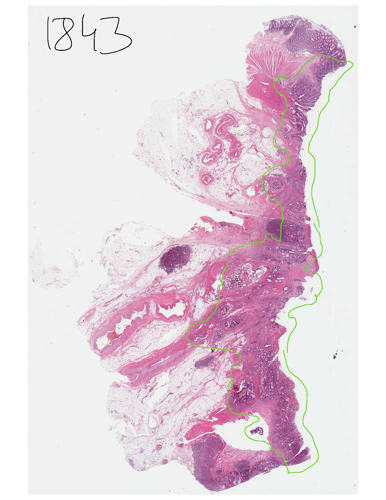

In [12]:
thumbnail(imshow(annotated_img), (500,500))

## Detect picture area

In [13]:
annotated_img_gray = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2GRAY)
#Threshold image to darken slide area 
annotated_img_thresh = cv2.threshold(annotated_img_gray, 250, 255, cv2.THRESH_BINARY)[1]

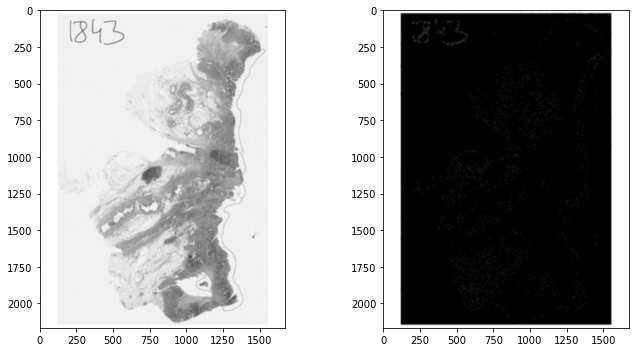

In [14]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
axs[0].imshow(annotated_img_gray, cmap = 'gray', interpolation = 'bicubic')
axs[1].imshow(annotated_img_thresh, cmap = 'gray', interpolation = 'bicubic')
fig.tight_layout()

In [15]:
#Fill white holes in the black slide area
kernal_5 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
opened = cv2.morphologyEx(annotated_img_thresh, cv2.MORPH_OPEN, kernal_5)

#Find where the slide area is
horizontal_px_sums = np.sum(opened, axis = 1).astype(np.int64)
horizontal_threshold = (np.min(horizontal_px_sums) + np.max(horizontal_px_sums))/2

vertical_px_sums = np.sum(opened, axis = 0).astype(np.int64)
vertical_threshold = (np.min(vertical_px_sums) + np.max(vertical_px_sums))/2

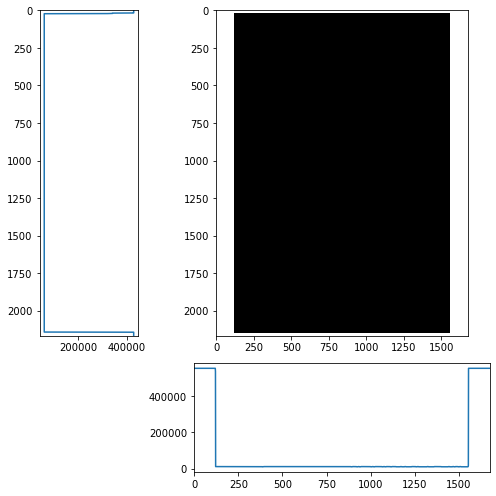

In [16]:
plt.figure(figsize = (7,7))
gs = gridspec.GridSpec(2,2, width_ratios = [1, 3], height_ratios = [3, 1])
ax = plt.subplot(gs[0,1])
axl = plt.subplot(gs[0,0], sharey = ax)
axl = axl.plot(horizontal_px_sums, range(len(horizontal_px_sums)))
#axl.axvline(horizontal_threshold)
axb = plt.subplot(gs[1,1], sharex = ax)
axb = axb.plot(vertical_px_sums)
ax.imshow(opened, cmap = 'gray')
plt.tight_layout()

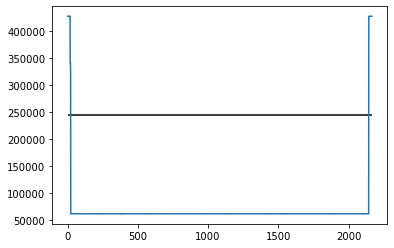

In [17]:
plt.plot(horizontal_px_sums)
plt.hlines(horizontal_threshold, 0, len(horizontal_px_sums))

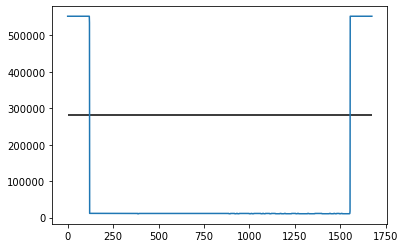

In [18]:
plt.plot(vertical_px_sums)
plt.hlines(vertical_threshold, 0, len(vertical_px_sums))

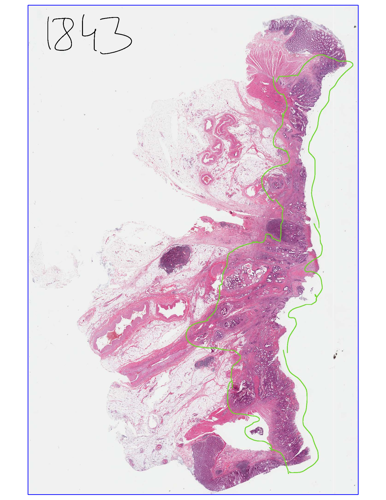

In [19]:
#Determine Y-bounds of slide area
img_rows = np.where(horizontal_px_sums < horizontal_threshold)
y_top = np.min(img_rows)
y_bottom = np.max(img_rows)

#Determine X-bounds of slide area
img_columns = np.where(vertical_px_sums < vertical_threshold)
x_left = np.min(img_columns)
x_right = np.max(img_columns)

#Draw a blue bounding box around the detected slide area
annotated_img_box = annotated_img.copy()
annotated_img_box = cv2.rectangle(annotated_img_box, (x_left, y_top), (x_right, y_bottom), (255,0,0), 2)
verbose_save_img(imshow(annotated_img_box), OUTPUT_PATH.joinpath(annotated_img_prefix + '_bounding_box.jpeg'), 'JPEG')
thumbnail(imshow(annotated_img_box), (500,500))

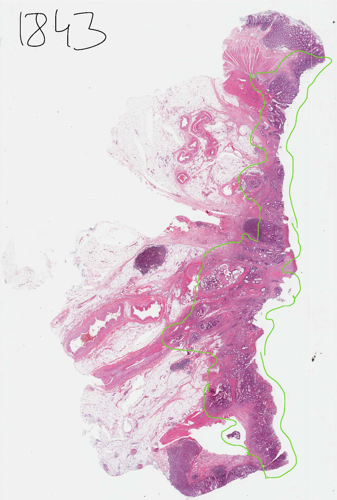

In [20]:
#Crop the annotated image to just the slide area
annotated_slide = annotated_img[y_top:y_bottom, x_left:x_right]

thumbnail(imshow(annotated_slide), (500,500))

## Detect Annotation Lines

In [21]:
# #For each unique colour find how many pixels have that colour
# px_array_2D = annotated_slide.reshape(-1, annotated_img.shape[-1])
# colours, counts = np.unique(px_array_2D, axis = 0, return_counts = True)
# colours = colours.astype(np.int16)

Faster implementations available at: https://stackoverflow.com/questions/50899692/most-dominant-color-in-rgb-image-opencv-numpy-python

In [25]:
#Find the most common colours
# top_colours = [x for _, x in sorted(zip(counts, colours), key = lambda pair:pair[0], reverse = True)]

In [26]:
# def is_gray(bgr_array, tolerance = 3):
#     b, g, r = bgr_array[0], bgr_array[1], bgr_array[2]
#     bg_diff, br_diff, gr_diff = abs(b-g), abs(b-r), abs(g-r)
#     return (bg_diff < tolerance) and (br_diff < tolerance) and (gr_diff < tolerance)

In [27]:
# top_colours_filtered = [colour for colour in top_colours if not is_gray(colour, 30)]

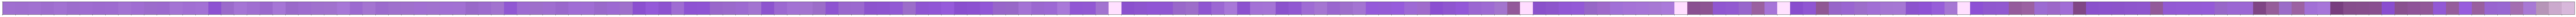

In [28]:
#Plot most common colours
# sns.palplot([colour/255 for colour in top_colours_filtered[:200]])

In [28]:
#Find top colours with a high value
# top_colours_red = [colour for colour in top_colours_filtered if colour[2] > 150]

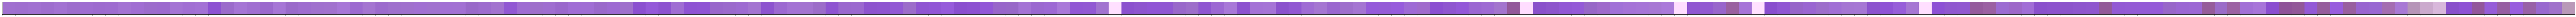

In [29]:
# sns.palplot([colour/255 for colour in top_colours_red[:200]])

In [42]:
# annotated_slide_hsv = cv2.cvtColor(annotated_slide, cv2.COLOR_BGR2HSV)
# annotated_slide_lab = cv2.cvtColor(annotated_slide, cv2.COLOR_BGR2LAB)

In [43]:
# #Testing red detection with HSV
# # Range for lower red
# lower_red = np.array([0, 20, 50])
# upper_red = np.array([30, 255, 255])
# lower_mask = cv2.inRange(annotated_slide_hsv, lower_red, upper_red)

# #Range for upper range
# lower_red = np.array([170, 150, 100])
# upper_red = np.array([180, 255, 255])
# upper_mask = cv2.inRange(annotated_slide_hsv, lower_red, upper_red)

# annotation_mask = lower_mask + upper_mask

In [44]:
# lower_red = np.array([80, 160, 130])
# upper_red = np.array([255, 255, 255])

# annotation_mask = cv2.inRange(annotated_slide_lab, lower_red, upper_red)

# thumbnail(imshow(annotation_mask))

In [45]:
# kernal_2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
# annotation_mask_opened = cv2.morphologyEx(annotation_mask, cv2.MORPH_OPEN, kernal_2)

In [21]:
# order of colours is bgr
# Green detection bounds
lower_colour_bounds = (0, 150, 0)
upper_colour_bounds = (150, 255, 200)

#Red detection bounds
# lower_colour_bounds = (50, 50, 160)
# upper_colour_bounds = (150, 150, 255)

annotation_mask = cv2.inRange(annotated_img, lower_colour_bounds, upper_colour_bounds)

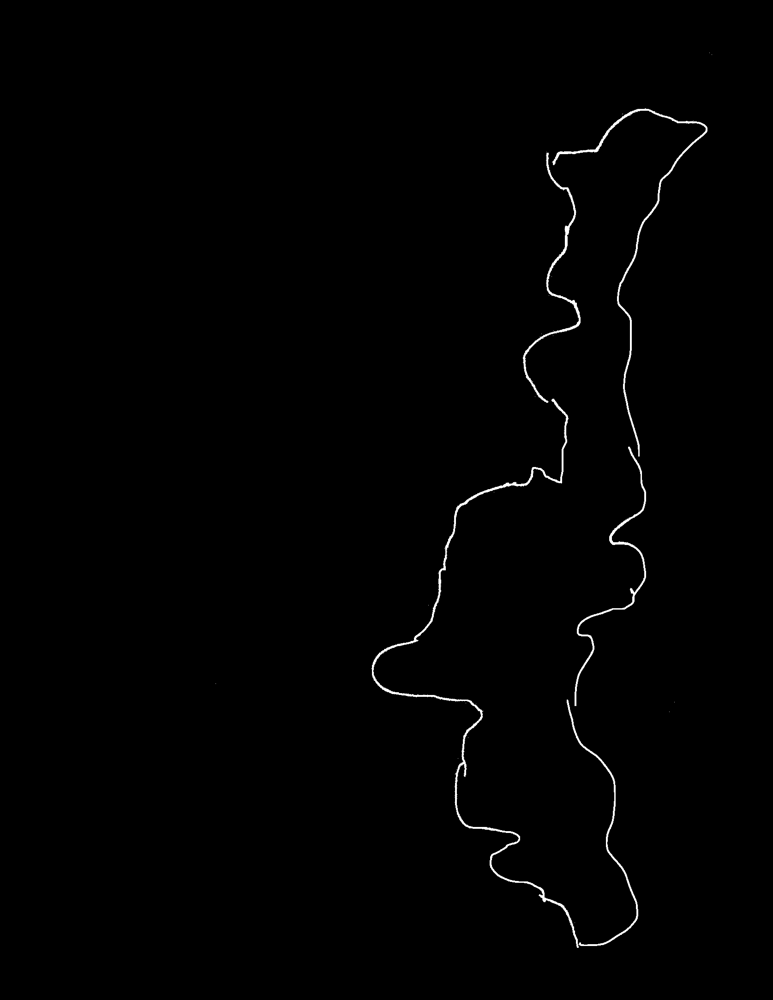

In [22]:
thumbnail(imshow(annotation_mask))

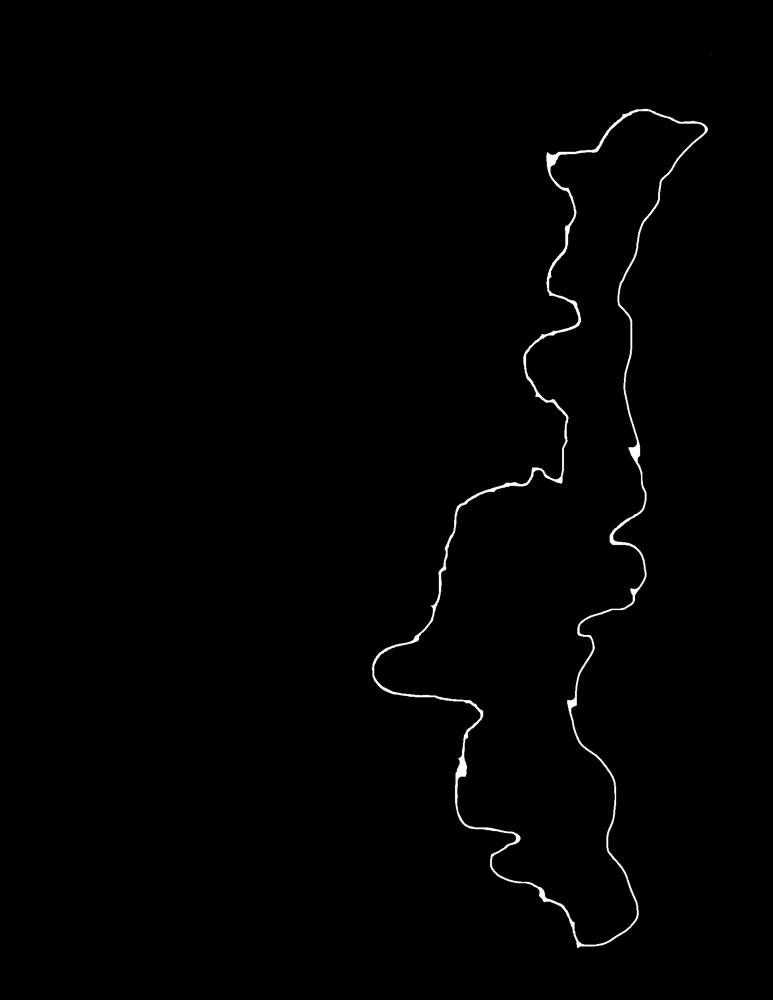

In [23]:
# Fill gaps in contour
kernal_20 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20,20))
annotation_mask_closed = cv2.morphologyEx(annotation_mask, cv2.MORPH_CLOSE, kernal_20)
thumbnail(imshow(annotation_mask_closed))

In [24]:
#Pad annotation mask 
PAD_WIDTH = 10
annotation_mask_pad = np.pad(annotation_mask_closed, pad_width = PAD_WIDTH, mode = 'maximum')

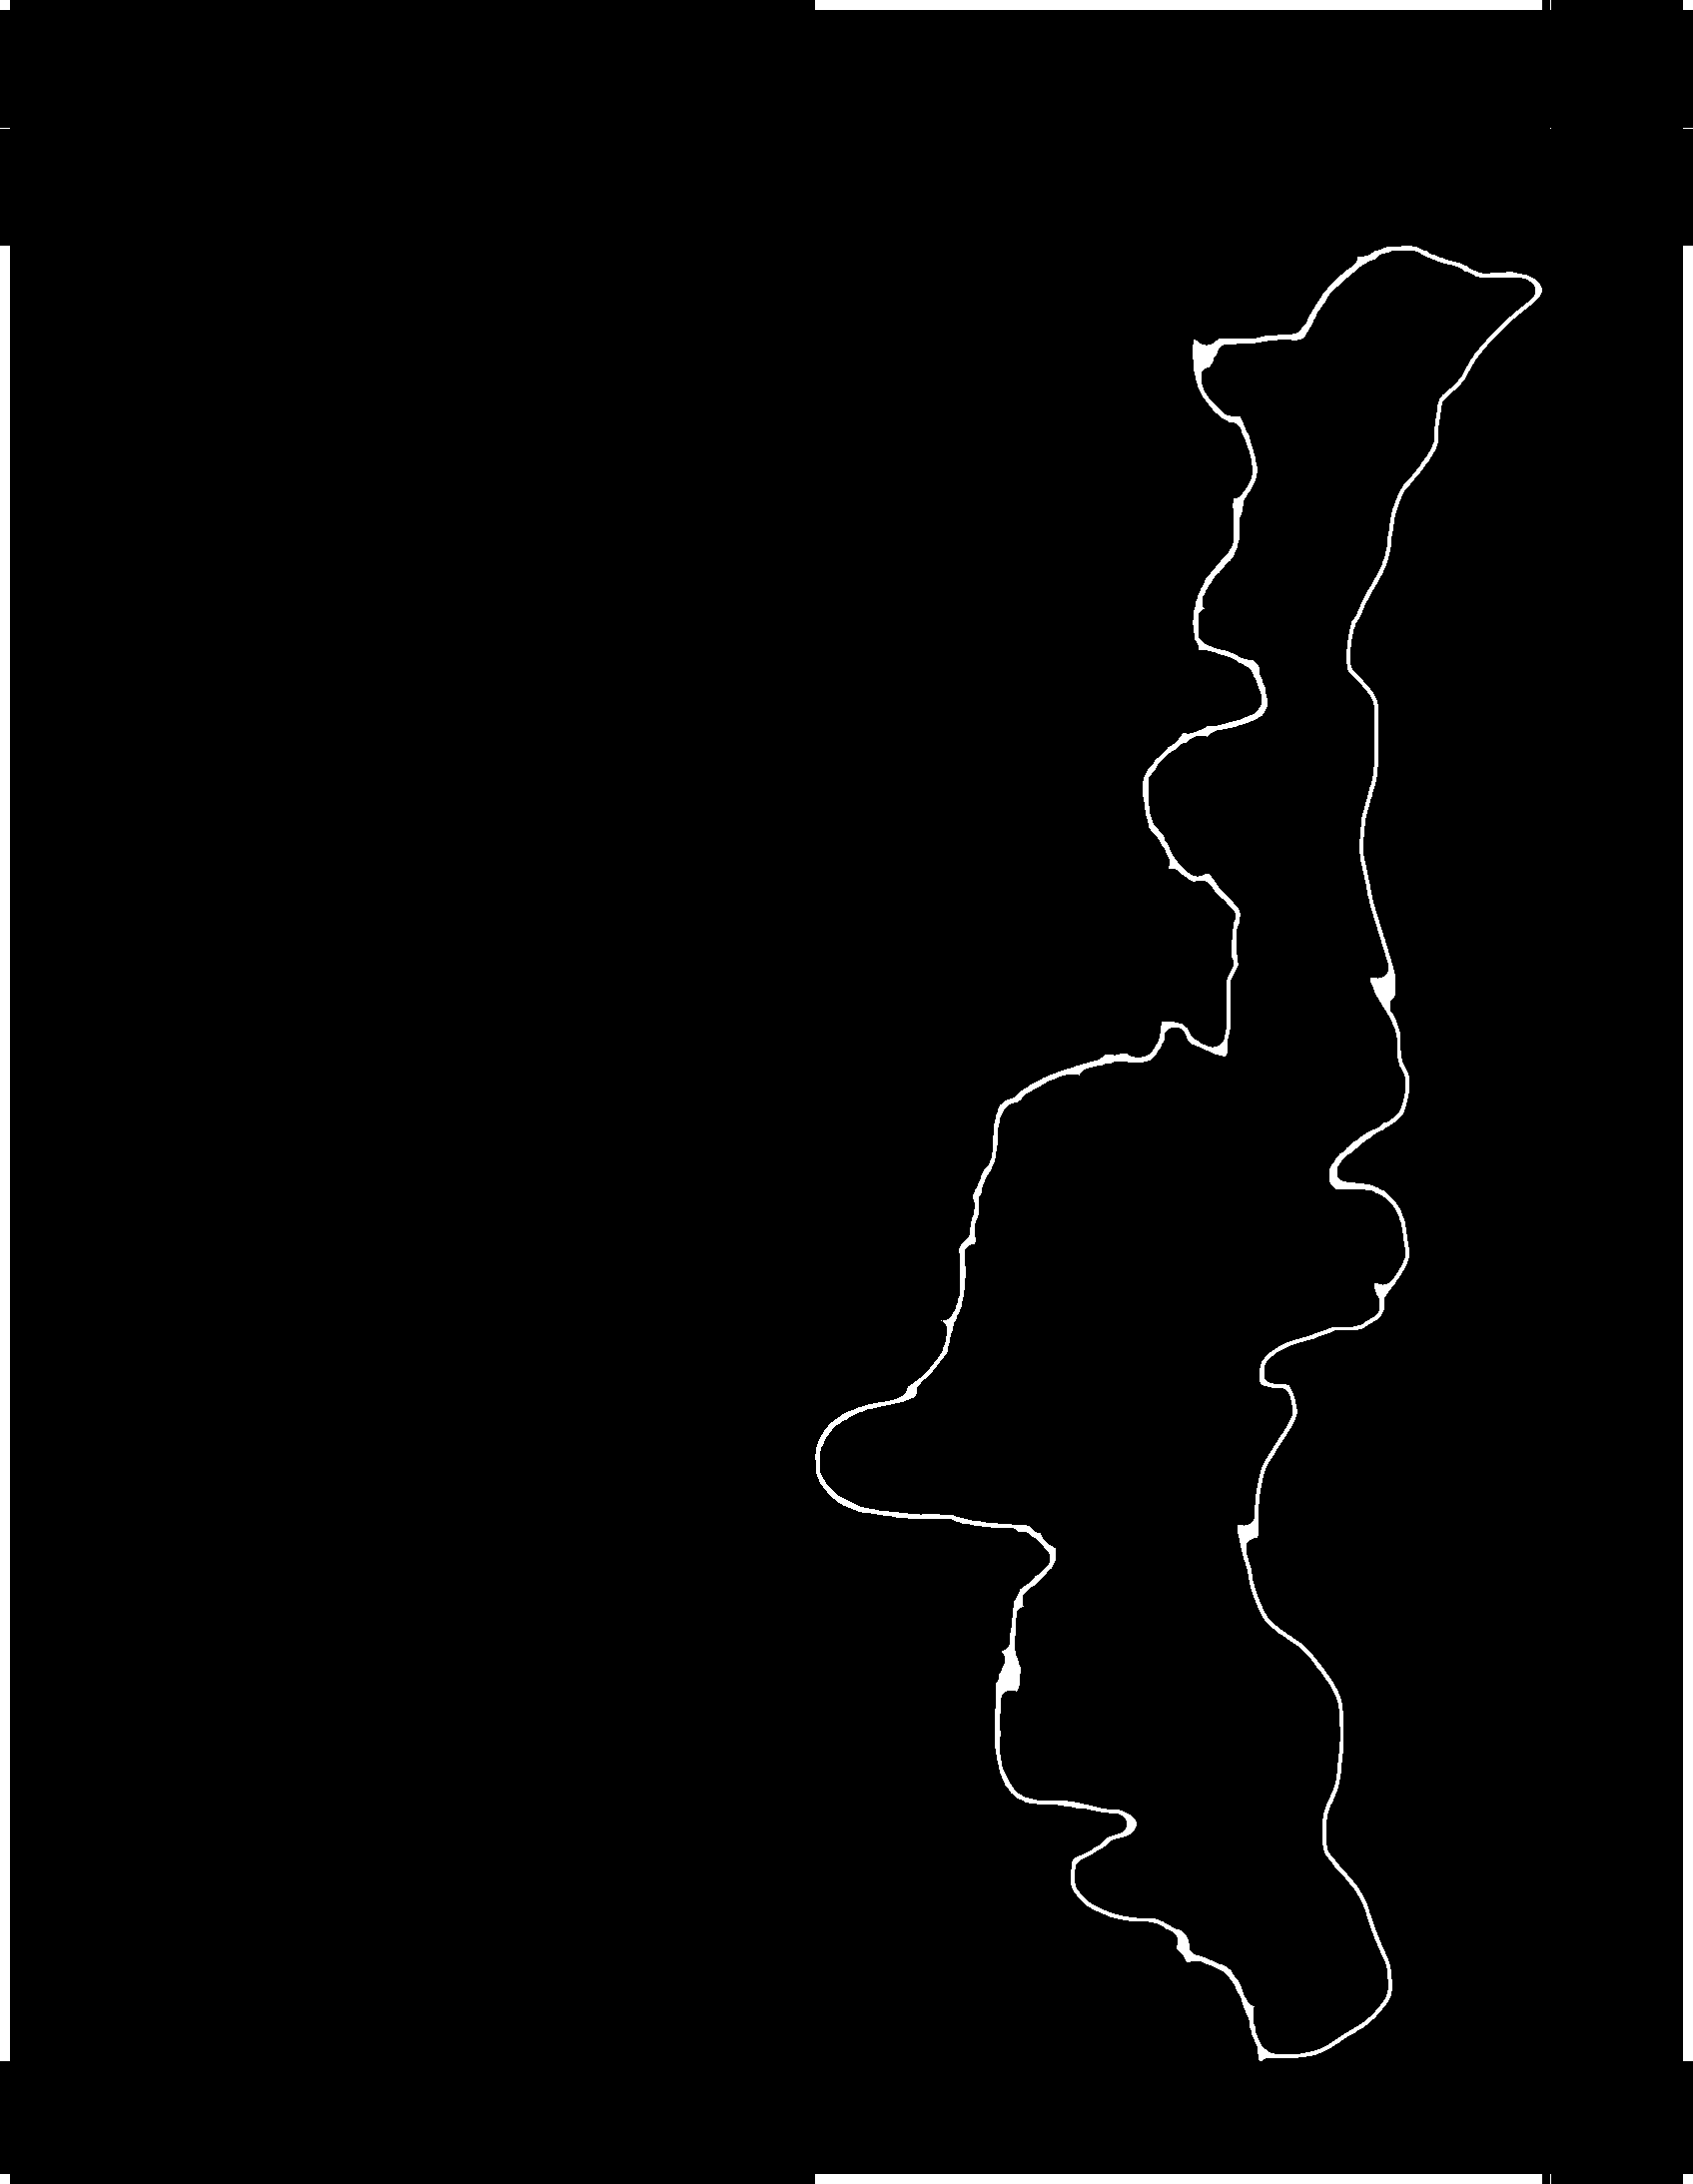

In [25]:
imshow(annotation_mask_pad)

In [26]:
# # Fill gaps in contour 
# kernal = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20,20))
# dilated = cv2.dilate(annotation_mask, kernal)
# eroded = cv2.erode(dilated, kernal)
# imshow_gray(eroded)

In [27]:
contours, hierachy = cv2.findContours(annotation_mask_pad, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [28]:
#Calculate how long each contour is
perimeters = np.array([cv2.arcLength(cnt, True) for cnt in contours])
#np.argmax(perimeters)

In [29]:
hierachy

array([[[ 1, -1, -1, -1],
        [ 2,  0, -1, -1],
        [ 3,  1, -1, -1],
        [ 4,  2, -1, -1],
        [ 5,  3, -1, -1],
        [ 6,  4, -1, -1],
        [ 8,  5,  7, -1],
        [-1, -1, -1,  6],
        [ 9,  6, -1, -1],
        [10,  8, -1, -1],
        [11,  9, -1, -1],
        [12, 10, -1, -1],
        [13, 11, -1, -1],
        [14, 12, -1, -1],
        [15, 13, -1, -1],
        [-1, 14, -1, -1]]], dtype=int32)

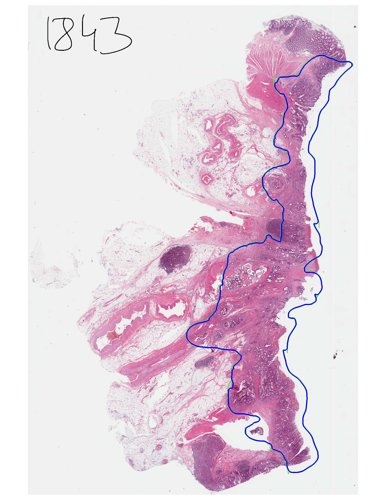

In [71]:
# Display the longest contour
longest_contour = contours[np.argmax(perimeters)] - (PAD_WIDTH, PAD_WIDTH)
longest_contour_overlay = cv2.drawContours(annotated_img.copy(), [longest_contour], 0,  (255, 0, 0), 3)
thumbnail(imshow(longest_contour_overlay), (500, 500))

To find contours that wrap around our annotations, we want to get the parent contours. <br>
The parent contours are found by selecting contours that have a child (i.e. the 3rd column of hierachy is not -1)

In [33]:
hierachy[0][hierachy[0][:,2] != -1]

array([[ 8,  5,  7, -1]], dtype=int32)

In [34]:
parent_cnts = np.where(hierachy[0][:,2]!= -1)[0]
parent_cnts

array([6])

In [44]:
first_childs = hierachy[0][parent_cnts][:, 2]
first_childs

array([7], dtype=int32)

In [45]:
first_child_perimeters = perimeters[first_childs]
first_child_perimeters

array([5557.45948184])

In [46]:
parent_cnt_perimeters = perimeters[parent_cnts]
parent_cnt_perimeters

array([5544.48891509])

In [47]:
#Filter parent contours such that the first child contour is a least a certain proportion of its length
cnt_proportion_thresh = 0.10 
parent_cnts_filtered = parent_cnts[(first_child_perimeters/parent_cnt_perimeters) >= cnt_proportion_thresh]
parent_cnts_filtered

array([6])

In [48]:
cnt_mask = np.zeros(annotation_mask_pad.shape[0:2])
for i in parent_cnts_filtered:
    cnt = contours[i]
    cnt_mask = cv2.drawContours(cnt_mask, [cnt], 0, 255, -1)
cnt_mask = cnt_mask.astype(np.uint8)
#Unpad countour mask by cropping image
cnt_mask = cnt_mask[PAD_WIDTH:cnt_mask.shape[0] - PAD_WIDTH, PAD_WIDTH:cnt_mask.shape[1] - PAD_WIDTH]

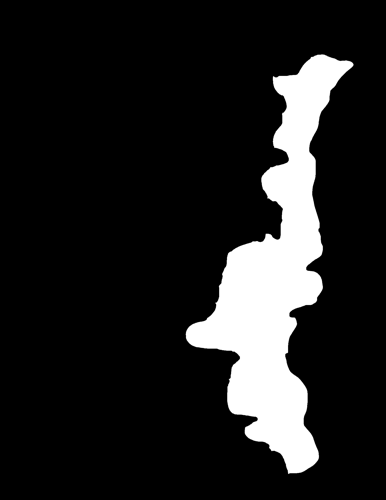

In [49]:
thumbnail(imshow(cnt_mask), (500,500))

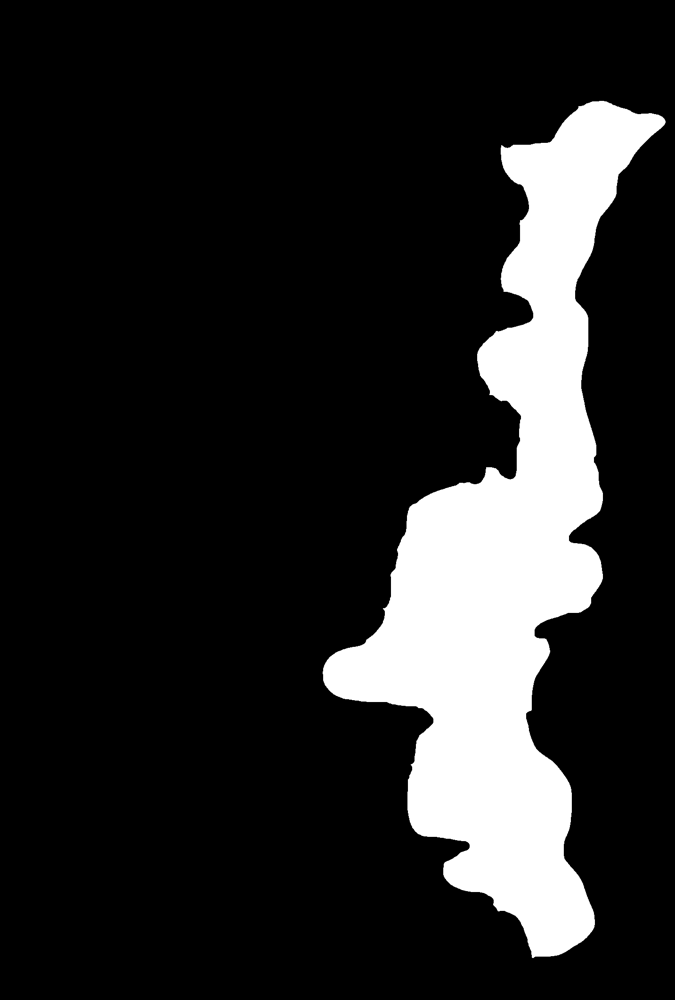

In [50]:
#Crop contour mask to slide area
cnt_mask_cropped = cnt_mask[y_top:y_bottom, x_left:x_right]

thumbnail(imshow(cnt_mask_cropped))

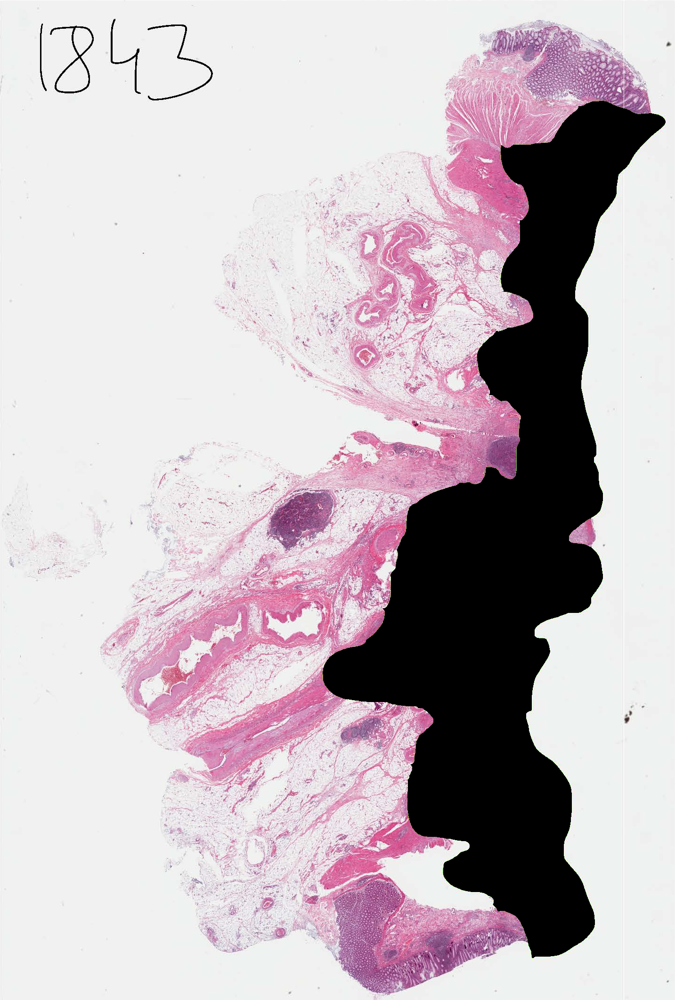

In [51]:
thumbnail(imshow(cv2.bitwise_and(annotated_slide, annotated_slide, mask = cv2.bitwise_not(cnt_mask_cropped))))

## Map to Slides

In [52]:
"""
Automatic slide detection with aspect ratio matching 
"""
he_imgs_df = pd.DataFrame(HE_slides, columns = ['HE_Slide_Name'])
he_imgs_pil = []
he_imgs_cv = []
for num in he_imgs_df.index:
    slide_name = he_imgs_df.loc[num, 'HE_Slide_Name']
    slide = open_slide(str(SLIDES_PATH.joinpath(slide_name)))
    img_pil = read_slide_at_mag(slide, 0.5).convert('RGB')
    img_cv = np.array(img_pil)[:, :, ::-1]   #Convert RGB to BGR
    he_imgs_pil.append(img_pil)
    he_imgs_cv.append(img_cv)
    he_imgs_df.loc[num, 'Max_Aspect_Ratio'] = max(img_pil.size)/min(img_pil.size)

In [53]:
#Find slide with most comparable aspect ratio
max_aspect_ratio = max(annotated_slide.shape[0:2])/min(annotated_slide.shape[0:2])
verbose_print('Max. Aspect Ratio of annotated slide is: {0}'.format(max_aspect_ratio))
aspect_ratio_diffs = [abs(x - max_aspect_ratio) for x in he_imgs_df['Max_Aspect_Ratio']]
img_num = np.argmin(aspect_ratio_diffs)

Max. Aspect Ratio of annotated slide is: 1.4801116538729937


In [54]:
he_imgs_df.loc[img_num]

HE_Slide_Name       1843_T_9561_3_HandE.svs
Max_Aspect_Ratio                     1.4799
Name: 5, dtype: object

In [55]:
PREFIX_SHORT = None
if PREFIX_SHORT:
    SLIDE_NUM = np.argmax([PREFIX_SHORT in slide_name for slide_name in HE_slides])
else:
    SLIDE_NUM = img_num
PREFIX = Paired_slides[SLIDE_NUM][0][:-8]
verbose_print('Processing Slide: {0}'.format(PREFIX))
tp53_name, he_name = Paired_slides[SLIDE_NUM]
tp53_slide = open_slide(str(SLIDES_PATH.joinpath(tp53_name)))
he_slide = open_slide(str(SLIDES_PATH.joinpath(he_name)))

Processing Slide: 1843_T_9561_2_


In [56]:
#Load Slides
he = read_slide_at_mag(he_slide, ALIGNMENT_MAG)
tp53 = read_slide_at_mag(tp53_slide, ALIGNMENT_MAG)

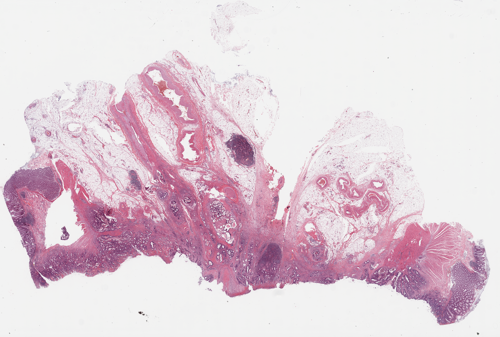

In [57]:
thumbnail(he, (500, 500))

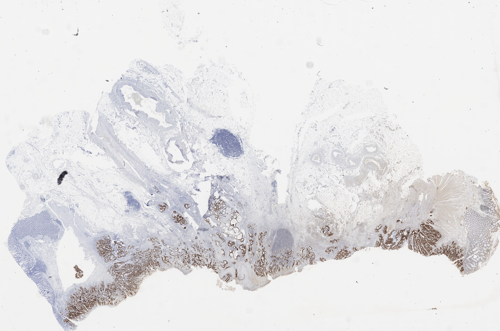

In [58]:
thumbnail(tp53, (500,500))

In [59]:
def correlation(img1, img2):
    """Pearson's Correlation Coefficient between two grayscale OpenCV images of the same size
    """
    img1_float, img2_float = np.float32(img1), np.float32(img2)
    mean1, sd1 = cv2.meanStdDev(img1)
    mean2, sd2 = cv2.meanStdDev(img2)
    n_pixels = img1.size
    covariance = (img1_float.ravel() - mean1[0]).dot((img2_float.ravel() - mean2[0]))/n_pixels
    return covariance/(sd1[0]*sd2[0])[0]

In [60]:
# correlation(he_cv_gray, he_cv_gray)

NameError: name 'he_cv_gray' is not defined

In [573]:
# he_cv_gray.shape[::-1]

(4582, 3940)

In [61]:
he_cv = np.array(he)[:, :, ::-1]   #Convert RGB to BGR
he_cv_gray = cv2.cvtColor(he_cv, cv2.COLOR_BGR2GRAY)
annotated_slide_gray = cv2.cvtColor(annotated_slide, cv2.COLOR_BGR2GRAY)

#Calculate how much to rotate H&E image
angles = [0,90,180, 270]
correlations = []
for angle in angles:
    annotated_slide_rotated = ndimage.rotate(annotated_slide_gray, angle)
    annotated_slide_resized =  cv2.resize(annotated_slide_rotated, he_cv_gray.shape[::-1], cv2.INTER_CUBIC)
    correlations.append(correlation(he_cv_gray, annotated_slide_resized))
ROTATION = angles[np.argmax(correlations)]

In [62]:
correlations

[0.07384742630627936,
 -0.15568883224240204,
 0.08297700180622687,
 0.8732266590927796]

In [63]:
ROTATION

270

In [64]:
#Normalise H&E slide against the template slide 
normaliser.fit_source(he)
he_norm = normaliser.transform_tile(he)

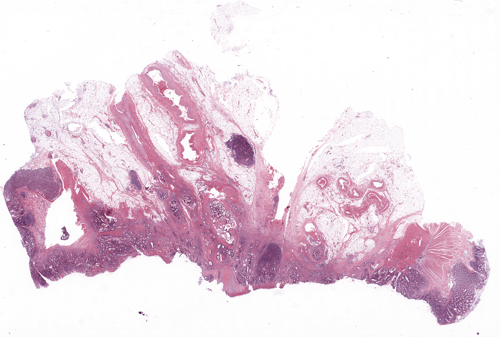

In [65]:
thumbnail(he_norm, (500,500))

In [66]:
#Rotate annotated slide to match actual slide image
#ROTATION = 90
annotated_slide_rotated = ndimage.rotate(annotated_slide, ROTATION)

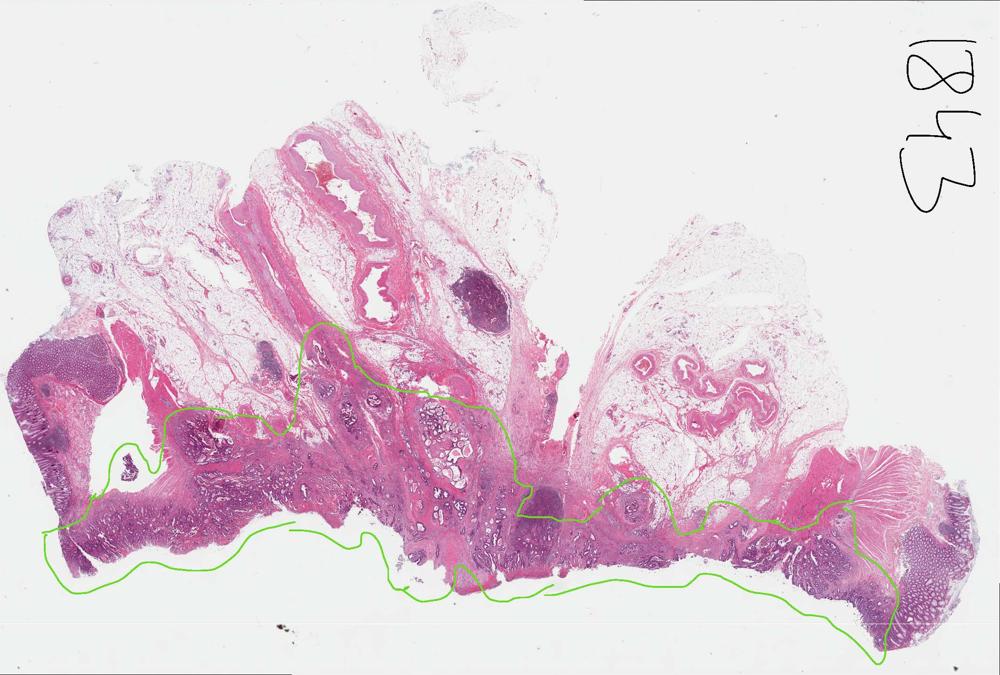

In [67]:
thumbnail(imshow(annotated_slide_rotated))

In [68]:
annotated_height, annotated_width = annotated_slide_rotated.shape[:2]
width, height = he_norm.size

In [69]:
annotated_slide_resized = cv2.resize(annotated_slide_rotated, he_norm.size, cv2.INTER_CUBIC)
annotated_slide_resized_pil = imshow(annotated_slide_resized)
verbose_save_img(annotated_slide_resized_pil, OUTPUT_PATH.joinpath(PREFIX + str(ALIGNMENT_MAG) + 'x_annotated_slide.jpeg'), 'JPEG')

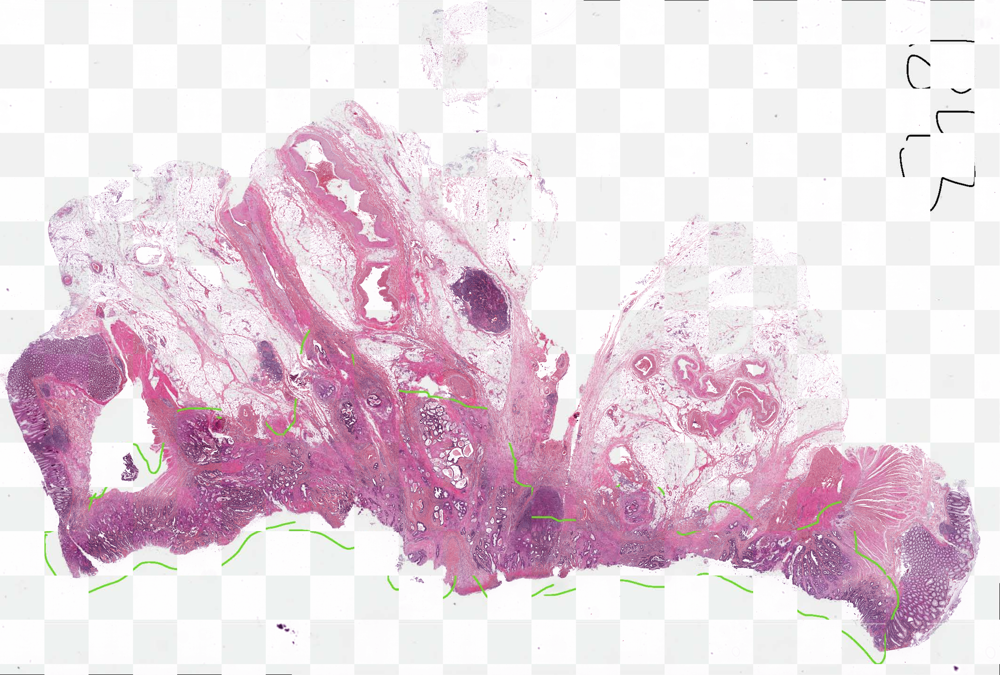

In [70]:
plotter = PlotImageAlignment('mosaic', 300)
annotation_alignment = plotter.plot_images(he_norm, annotated_slide_resized_pil)
verbose_save_img(annotation_alignment, OUTPUT_PATH.joinpath(PREFIX + str(ALIGNMENT_MAG) + 'x_annotation_alignment.jpeg'), 'JPEG')
thumbnail(annotation_alignment)

In [71]:
rotate_resize = lambda x, angle, size: cv2.resize(ndimage.rotate(x, angle), size, cv2.INTER_CUBIC)

#Rotate and scale masks to align it to the slide image
annotation_mask_aligned = rotate_resize(annotation_mask, ROTATION, he_norm.size)
annotation_mask_closed_aligned = rotate_resize(annotation_mask_closed, ROTATION, he_norm.size)
cnt_mask_aligned = rotate_resize(cnt_mask_cropped, ROTATION, he_norm.size)

annotation_mask_aligned_pil = imshow(annotation_mask_aligned)
annotation_mask_closed_aligned_pil = imshow(annotation_mask_closed_aligned)
cnt_mask_pil = imshow(cnt_mask_aligned)

prefix_align_mag = PREFIX + str(ALIGNMENT_MAG) + 'x_'

verbose_save_img(annotation_mask_aligned_pil, OUTPUT_PATH.joinpath(prefix_align_mag + 'annotation_mask.jpeg'), 'JPEG')
verbose_save_img(annotation_mask_closed_aligned_pil, OUTPUT_PATH.joinpath(prefix_align_mag + 'annotation_mask_closed.jpeg'), 'JPEG')
verbose_save_img(cnt_mask_pil, OUTPUT_PATH.joinpath(prefix_align_mag + 'annotation_mask_filled.jpeg'), 'JPEG')

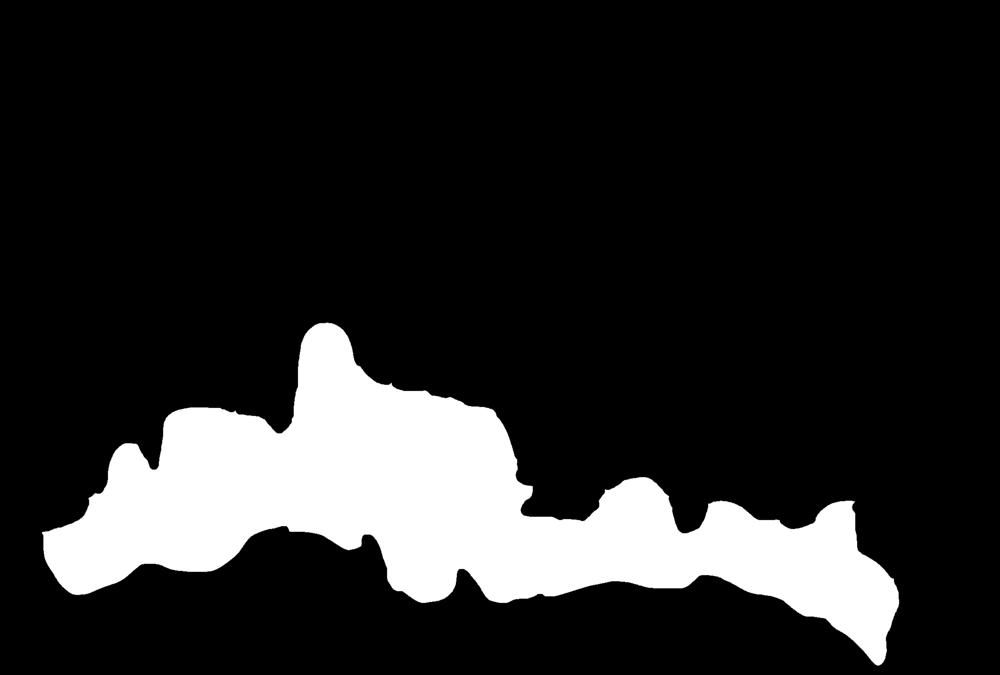

In [72]:
thumbnail(cnt_mask_pil)

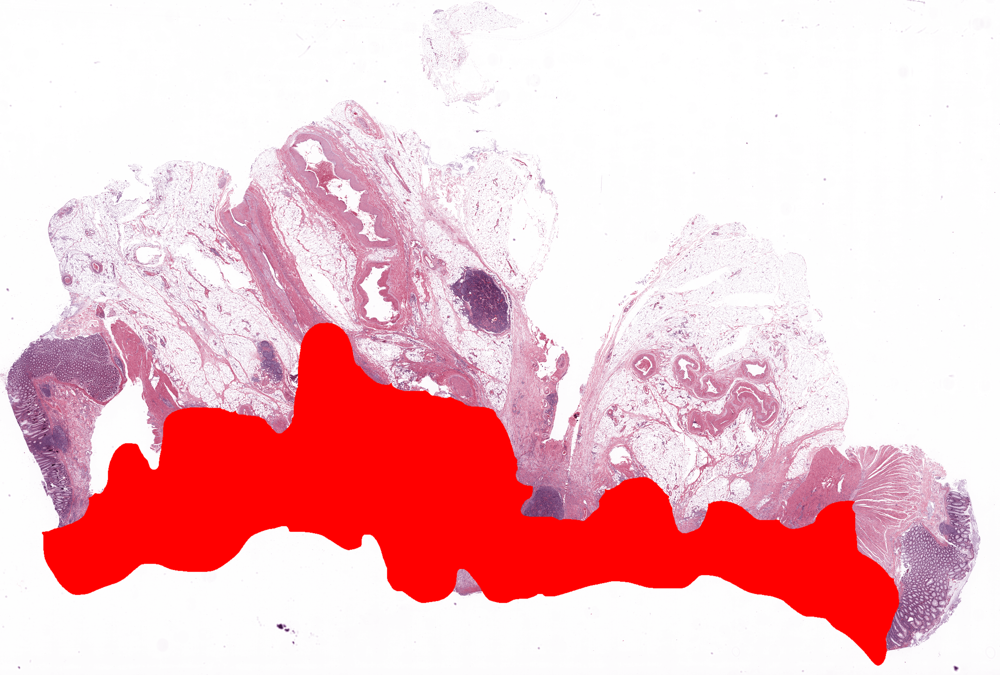

In [73]:
red_img = Image.new('RGB', (he_norm.size), (255, 0 ,0))
green_img = Image.new('RGB', (he_norm.size), (0, 255, 0))
slide_overlay = Image.composite(green_img, he_norm, annotation_mask_aligned_pil)
verbose_save_img(slide_overlay, OUTPUT_PATH.joinpath(prefix_align_mag + 'annotation_overlay.jpeg'), 'JPEG')
slide_overlay_filled = Image.composite(red_img, he_norm , cnt_mask_pil)
verbose_save_img(slide_overlay_filled, OUTPUT_PATH.joinpath(prefix_align_mag + 'annotation_overlay_filled.jpeg'), 'JPEG')
thumbnail(slide_overlay_filled)

In [74]:
tile_size = 299*ALIGNMENT_MAG/TILE_MAG

In [75]:
tgen = tile_gen(cnt_mask_pil, tile_size)
c_mask = np.invert(threshold_mask(tgen, 128).astype(np.bool))

In [76]:
def show_mask(mask):
    mask = mask.astype(np.uint8)
    plt.imshow(np.reshape(mask, mask.shape[::-1]))
    plt.colorbar()

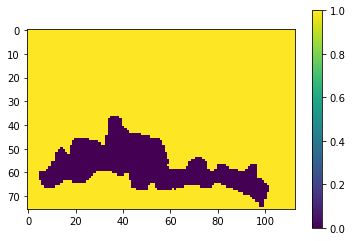

In [77]:
show_mask(c_mask)

In [78]:
#Remove background from H&E Image
he_filtered = filter_green(he_norm)
he_filtered = filter_grays(he_filtered, tolerance = 15)

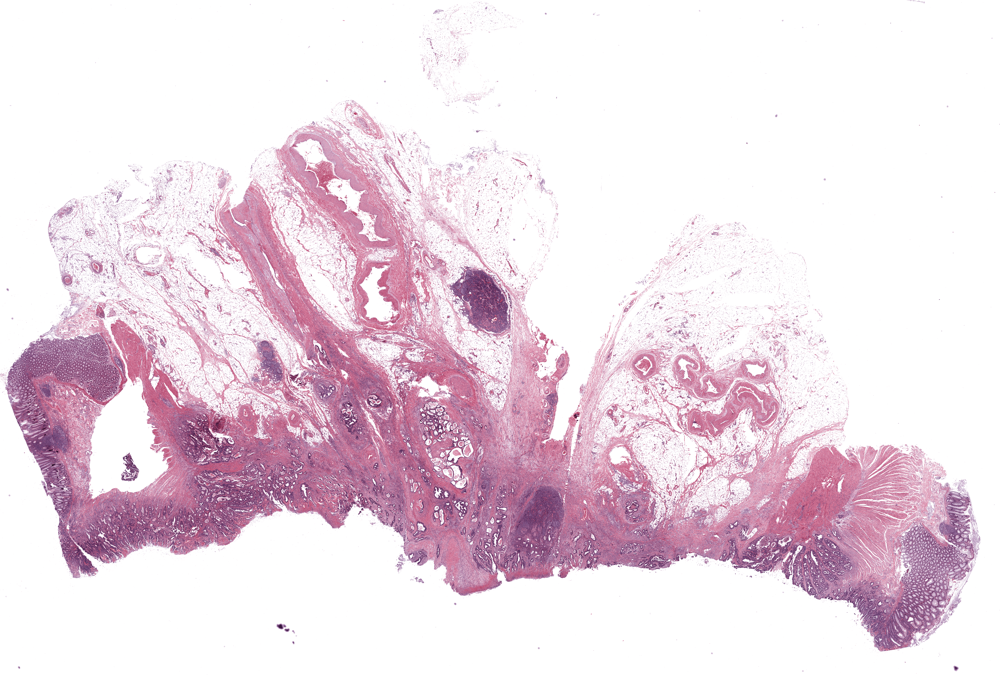

In [79]:
thumbnail(he_filtered)

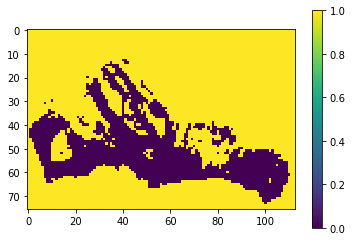

In [80]:
t_mask_he = tissue_mask(he_filtered, tile_size, 0.01)

show_mask(t_mask_he)

In [81]:
#Make sure all cancer tiles exist in the tissue mask
c_mask_filtered = np.logical_not(np.logical_not(c_mask) & np.logical_not(t_mask_he))

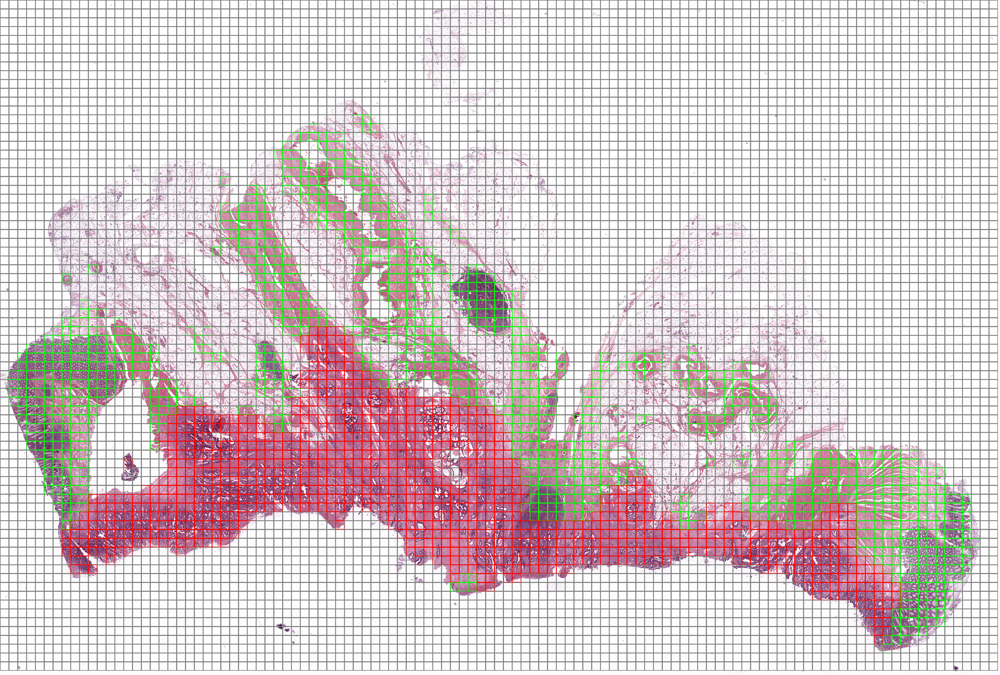

In [82]:
overlay_he = plot_masks(he_norm, c_mask_filtered, t_mask_he, tile_size, width_proportion = 0.07)
verbose_save_img(overlay_he, OUTPUT_PATH.joinpath(PREFIX + str(ALIGNMENT_MAG) + 'x_tile_labels.jpeg'), 'JPEG')
thumbnail(overlay_he)

In [74]:
cancer_tiles = np.sum(np.invert(c_mask_filtered))
cancer_tiles 

660

In [75]:
non_cancer_tiles = np.sum(np.invert(t_mask_he.astype(np.bool))) - cancer_tiles
non_cancer_tiles

1229

In [76]:
tile_counts_df = tile_counts_df.append({'prefix': PREFIX, 'cancer': cancer_tiles, 'non-cancer': non_cancer_tiles}, ignore_index = True)

In [77]:
tile_counts_df

prefix  cancer  non-cancer
0  1928_T_9644_2_   660.0      1229.0

In [638]:
combinations = [list(x) for x in list(itertools.combinations(range(tile_counts_df.shape[0]), 5))]
best_sample = {'cancer_sum': None, 'non_cancer_sum': None, 'ratio': 10, 'combination': None}
for i in range(len(combinations)):
    tile_count_sums = tile_counts_df.loc[combinations[i]].sum()
    ratio = tile_count_sums['cancer']/tile_count_sums['non-cancer']
    if abs(1-ratio) < abs(1- best_sample['ratio']):
        best_sample['cancer_sum'] = tile_count_sums['cancer']
        best_sample['non_cancer_sum'] = tile_count_sums['non-cancer']
        best_sample['ratio'] = ratio
        best_sample['combination'] = i

In [639]:
best_sample

{'cancer_sum': 5197.0,
 'non_cancer_sum': 5204.0,
 'ratio': 0.9986548808608763,
 'combination': 16}

In [640]:
combinations[16]

[1, 2, 3, 4, 6]

In [331]:
# tile_counts_df = tile_counts_df.drop(1, axis = 0)

In [78]:
##############
# Save Tiles #
##############

#Make Directory to save tiles
TILES_PATH = OUTPUT_PATH.joinpath('tiles_' + str(TILE_MAG) + 'x') 
os.makedirs(TILES_PATH, exist_ok = True)

In [600]:
def save_annotation_tiles(path, tile_gen, cancer_mask, tissue_mask, prefix = ''):
    os.makedirs(path.joinpath('cancer'), exist_ok = True)
    os.makedirs(path.joinpath('non-cancer'), exist_ok = True)
    os.makedirs(path.joinpath('other'), exist_ok = True)
    x_tiles, y_tiles = next(tile_gen)
    verbose_print('Whole Image Size is {0} x {1}'.format(x_tiles, y_tiles))
    i = 0 
    tile_counts = {'cancer': 0, 'non-cancer': 0, 'other': 0 }
    for tile in tile_gen:
        img = tile.convert('RGB')
        ###
        img_norm = normaliser.transform_tile(img)
        ###
        #Name tile as horizontal position _ vertical position starting at (0,0)
        tile_name = prefix + str(np.floor_divide(i,x_tiles)) + '_' +  str(i%x_tiles) 
        if cancer_mask.ravel()[i] == 0:
            img_norm.save(path.joinpath('cancer', tile_name + '.jpeg'), 'JPEG')
            tile_counts['cancer'] += 1
        elif tissue_mask.ravel()[i] == 0:
            img_norm.save(path.joinpath('non-cancer', tile_name + '.jpeg'), 'JPEG')
            tile_counts['non-cancer'] += 1
        else:
            img_norm.save(path.joinpath('other', tile_name + '.jpeg'), 'JPEG')
            tile_counts['other'] += 1
        i += 1
    verbose_print('Exported tiles for {0}'.format(prefix))
    return tile_counts

In [601]:
tgen = tile_gen_at_mag(he_slide, TILE_MAG, 299)
tile_counts = save_annotation_tiles(TILES_PATH, tgen, c_mask_filtered, t_mask_he, prefix = PREFIX)

Whole Image Size is 76 x 65
Exported tiles for 1928_T_9644_2_


In [602]:
tile_counts

{'cancer': 660, 'non-cancer': 1229, 'other': 3051}